In [1]:
import torch
import numpy as np
from torchvision import datasets
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF

import cv2
from PIL import Image
import matplotlib.pyplot as plt                        
%matplotlib inline   

__Data:__ Build the dataloaders. Be sure every watermarked image has his corresponding clean image.

In [2]:
from glob import glob

#path images with watermark
wm_images = np.array(glob("./watermarked3/*"))
#path original images
or_images = np.array(glob("./pure3/*"))


if (len(wm_images)!=len(or_images)):
    print ("Error: The number of watermarked images and pure images isn't the same\n")
else:
    l_index = len(wm_images)
       
print ("Count watermarked images: {}\t Count pure images: {}".format(len(wm_images),len(or_images)))

Count watermarked images: 944	 Count pure images: 944


__Dataset:__ Modify the one from the pytorch tutorial. I want to link my clean image to the watermarked image. So that I can use the pytorch DataLoader

In [3]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
class MarkedAndPureDataset(Dataset):
    """Clean and Watermarked images."""

    def __init__(self, paths_pure, paths_wm, transform=None):
        """
        Args:
            paths_pure (list): list of pathes, one path to one pure image
            paths_wm (list): list of pathes, one path to one pure image
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.paths_pure = paths_pure
        self.paths_wm = paths_wm
        self.transform = transform

    def __len__(self):
        if len(self.paths_pure) == len(self.paths_wm):
            return len(self.paths_pure)
        else:
            return None

    def __getitem__(self, idx):
        img_name_pure = self.paths_pure[idx]
        img_name_wm = self.paths_wm[idx]
        image_pure = Image.open(img_name_pure)
        image_wm = Image.open(img_name_wm)
        #sample = image_pure,image_wm

        if self.transform:
            image_pure = self.transform(image_pure)
            image_wm = self.transform(image_wm)
            

        return image_pure, image_wm
    
    def info(self):
        return self.paths_wm

In [4]:
datas = MarkedAndPureDataset(or_images,wm_images,transform=transforms.ToTensor())
dataloader = DataLoader(datas, batch_size=4, shuffle=True)

__Check the dataloader:__ print some pure and the corresponding watermarked images

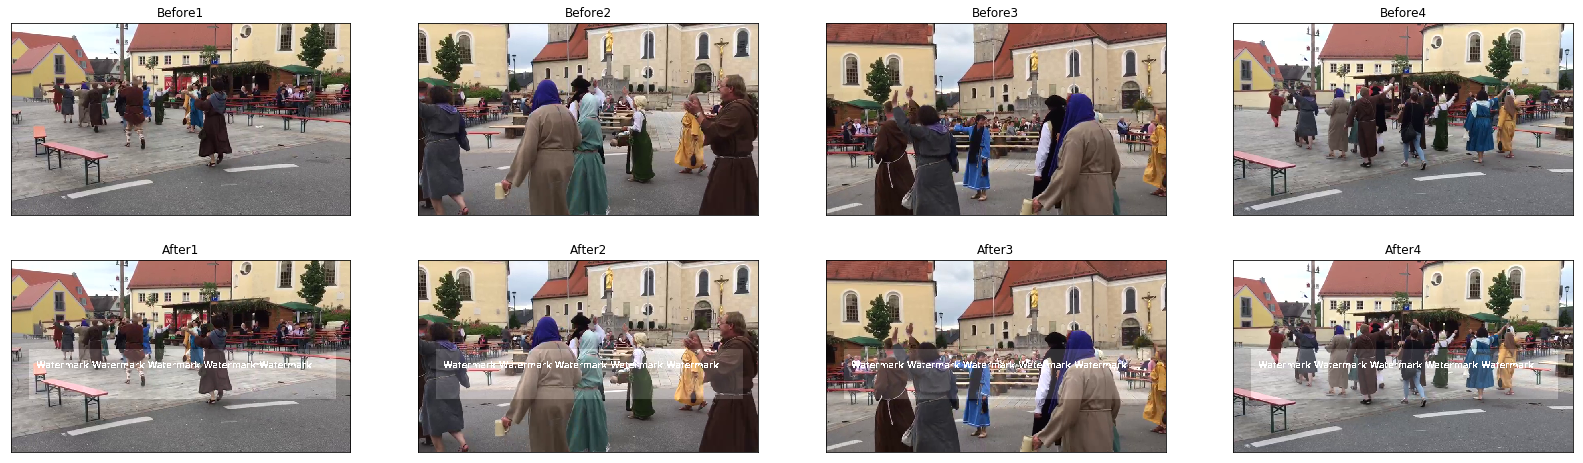

In [5]:
##print one batch, 4 pure & 4 watermarked images
for p_im, wm_im in dataloader:
    fig = plt.figure(figsize=(28,8))
    for ind in range(4):

        ax = fig.add_subplot(2,4,ind+1,xticks=[], yticks=[])
        plt.imshow(TF.to_pil_image(p_im[ind]))
        ax.set_title('Before'+str(ind+1))
        ax = fig.add_subplot(2,4,ind+5,xticks=[], yticks=[])
        plt.imshow(TF.to_pil_image(wm_im[ind]))
        ax.set_title('After'+str(ind+1))
        

    
    break

__Model:__ Build the model

In [6]:
import torch.nn as nn
import torch.nn.functional as F

class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.conv1 = nn.Conv2d(3, 12, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(12)
        self.conv2 = nn.Conv2d(12, 24, 3, padding =1)
        self.bn2 = nn.BatchNorm2d(24)
        self.conv3 = nn.Conv2d(24,48,3,padding=1)
        self.bn3 = nn.BatchNorm2d(48)
        self.conv4 = nn.Conv2d(48,24,3,padding=1)
        self.bn4 = nn.BatchNorm2d(24)
        self.conv5 = nn.Conv2d(24,12,3,padding=1)
        self.bn5 = nn.BatchNorm2d(12)
        
        self.conv_out = nn.Conv2d(12,3,3,padding=1)
        

    def forward(self, x):
        
        x = F.relu(self.bn1(self.conv1(x)))
        #x = self.pool(x)
        x = F.relu(self.bn2(self.conv2(x)))
        #x = self.pool(x)
        x = F.relu(self.bn3(self.conv3(x)))
        #x = self.pool(x)
        
        x = F.relu(self.bn4(self.conv4(x)))
        x = F.relu(self.bn5(self.conv5(x)))
        x = F.sigmoid(self.conv_out(x))
    
    
        return x
    
deNoiser = Model()
print (deNoiser)

Model(
  (conv1): Conv2d(3, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(12, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(24, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(48, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(24, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn5): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_out): Conv2d(12, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)


__Loss function and optimizer:__
Choose a Loss: No classification, more like a regression, thats why I start with MSE

In [7]:
criterion = nn.MSELoss()

#try this one out
optimizer = torch.optim.Adam(deNoiser.parameters(), lr=0.005)

In [8]:
def denoise_image(image):
    trnsf = transforms.ToTensor()
    image_Tensor = trnsf(image)
    output = deNoiser(image_Tensor.view(-1,3,480,848))
    return TF.to_pil_image(output.squeeze())
    

__Train & Validation:__

In [9]:
deNoiser.load_state_dict(torch.load("C:\\Users/Snoopy/GH_data4denoiser/deNoiser.pt"))

In [10]:
epoch = 5
valid_ima = wm_images[0]

for e in range (1,epoch+1):
    
    #I'm not sure if the loss in this case will help me
    loss_train = []
    
    
    for pu_im, wa_im in dataloader:
        
        optimizer.zero_grad()
        output = deNoiser(wa_im.view(-1,3,480,848))
        loss = criterion(output, pu_im.view(-1,3,480,848))
        loss.backward()
        optimizer.step()
        loss_train.append(loss)
        
    train_loss_mean = torch.tensor(loss_train).mean()   
    print("Epoch: {}\tTrain_loss:  {}".format(e,train_loss_mean))
    
    ###denoise a watermarked pic after each epoch and save it
    ###in the first step it's always the same pic
    valid1 = denoise_image(Image.open(valid_ima))
    valid1.save("C:\\Users/Snoopy/GH_data4denoiser/valid_pic"+str(e)+".png")  
    
    torch.save(deNoiser.state_dict(), "C:\\Users/Snoopy/GH_data4denoiser/deNoiser.pt") 

            
  
    


C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\functional.py:1332: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


KeyboardInterrupt: 

__Conclusion:__ ???